# Melanoma_Detection_Assignment


**Problem statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis. Build a multiclass classification model using a custom convolutional neural network in TensorFlow.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

### Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.regularizers import l2

model = models.Sequential

import os
import PIL

import pathlib
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Reading Training and Testing Data

In [ ]:
batch_size = 32
epochs = 20
input_image_height = 180
input_image_width = 180

#/content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration
training_data_dir = '/content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
testing_data_dir = '/content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Test/'


In [ ]:
data_dir_train = pathlib.Path(training_data_dir)
data_dir_test  = pathlib.Path(testing_data_dir)

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Total images in training directory:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Total images in testing directory:", image_count_test)

Total images in training directory: 2239
Total images in testing directory: 118


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=123,
    validation_split=0.2,
    subset='training',
    label_mode='categorical',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=123,
    validation_split=0.2,
    subset='validation',
    label_mode='categorical',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
#print('Image per batch:', len(list(train_ds.as_numpy_iterator())))
print('Images in Train:', len(train_ds.file_paths))
print('Images in Validation:', len(val_ds.file_paths))

Images in Train: 1792
Images in Validation: 447


In [ ]:
class_names = train_ds.class_names
print('The Class Names are: ', class_names)

The Class Names are:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
## 2. Visualizing the data

## 2. Visualizing the data

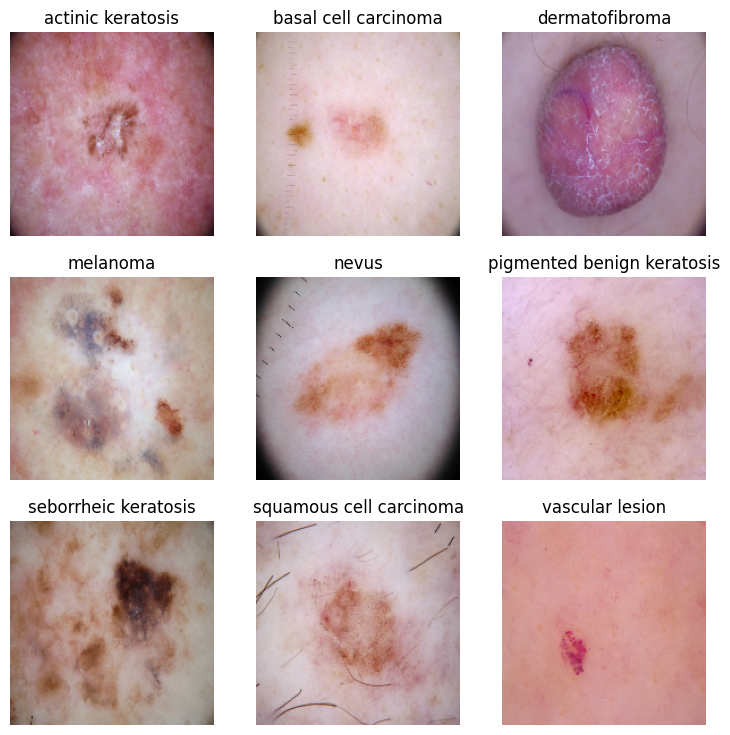

In [ ]:
i = 0
fig = plt.figure(figsize=(9,9))
for ind in range(len(class_names)):
    for img, lab in train_ds:
        #print(np.argmax(lab, axis=1)[0])
        if(np.argmax(lab, axis=1)[0] == ind):
            image = img
            break
    i = i + 1
    ax = plt.subplot(3, 3, i)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[ind])
    plt.axis('off')

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Create a Model & Training


#### 3.1. Training using Model 1

In [ ]:
def visualize_outputs(fit_data):
    acc = fit_data.history['accuracy']
    val_acc = fit_data.history['val_accuracy']

    loss = fit_data.history['loss']
    val_loss = fit_data.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
def get_model():
    model = keras.Sequential()
    model.add(keras.layers.Rescaling(1./255, input_shape=(input_image_height, input_image_width, 3)))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(Flatten())
    model.add(Dropout(0.15))
    #model.add(Dense(128, kernel_regularizer=l2(0.01)))
    #model.add(Dense(128))
    #model.add(Activation('relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(len(class_names), activation='softmax'))
    return model

In [ ]:
model = get_model()
model.build(train_ds.as_numpy_iterator().next()[0].shape)

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 179, 179, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 179, 179, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 178, 178, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 178, 178, 32)      1

In [ ]:
### Todo, choose an appropirate optimiser and loss function
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, weight_decay=1e-6)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = model.fit(train_ds, epochs = epochs, validation_data=val_ds)


Epoch 1/20
56/56 [==============================] - 64s 910ms/step - loss: 2.0619 - accuracy: 0.2132 - val_loss: 1.9982 - val_accuracy: 0.2349
Epoch 2/20
56/56 [==============================] - 10s 187ms/step - loss: 1.9752 - accuracy: 0.2461 - val_loss: 1.9324 - val_accuracy: 0.2103
Epoch 3/20
56/56 [==============================] - 11s 203ms/step - loss: 1.8883 - accuracy: 0.3030 - val_loss: 1.9100 - val_accuracy: 0.3020
Epoch 4/20
56/56 [==============================] - 11s 195ms/step - loss: 1.7914 - accuracy: 0.3465 - val_loss: 1.6706 - val_accuracy: 0.4318
Epoch 5/20
56/56 [==============================] - 11s 194ms/step - loss: 1.6390 - accuracy: 0.4152 - val_loss: 1.5550 - val_accuracy: 0.4430
Epoch 6/20
56/56 [==============================] - 11s 194ms/step - loss: 1.5839 - accuracy: 0.4414 - val_loss: 1.7264 - val_accuracy: 0.3848
Epoch 7/20
56/56 [==============================] - 11s 193ms/step - loss: 1.5467 - accuracy: 0.4464 - val_loss: 1.5522 - val_accuracy: 0.4474

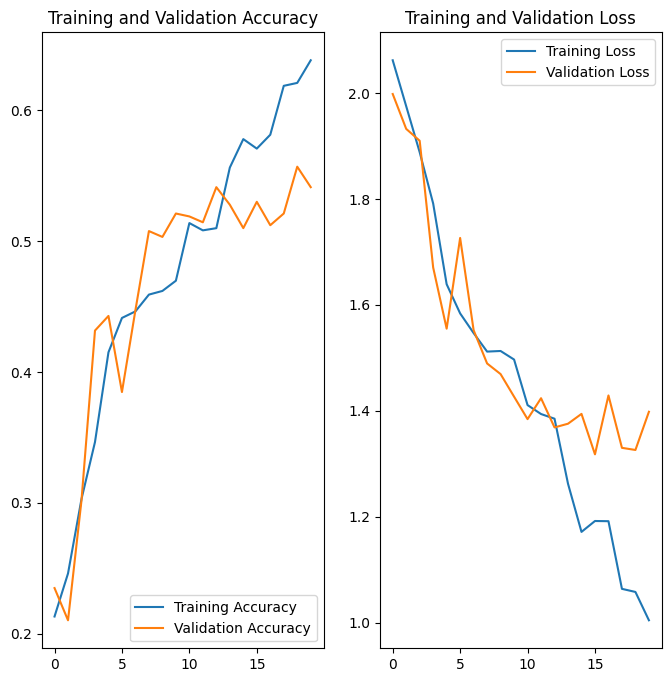

In [ ]:
visualize_outputs(hist)

##### Observations

- There is a significant difference between the training accuracy and the validation accuracy on higher epochs.
- Also, the error rate has also increased for the validation data.
- This could be a reason for overfitting.
- Also, the training accuracy is not high enough. This can be due to less amount of data to learn. To increase the training samples, we will augment the data.
- Augmentation tries to randomly flip/rotate/zoom the images and add them as new images.
- These can help model learn better...

## 4. Handle Overfitting using Augmentation


In [ ]:
path_list_old = list(data_dir_train.glob('*/*.jpg'))
print("Existing Images Count:", len(path_list_old))

lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in path_list_old]
print(set(lesion_list_old), " Categories of Existing Generated Image files:",  len(lesion_list_old))

dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))

df_old = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

Existing Images Count: 2239
{'seborrheic keratosis', 'vascular lesion', 'melanoma', 'actinic keratosis', 'squamous cell carcinoma', 'pigmented benign keratosis', 'dermatofibroma', 'nevus', 'basal cell carcinoma'}  Categories of Existing Generated Image files: 2239


<BarContainer object of 9 artists>

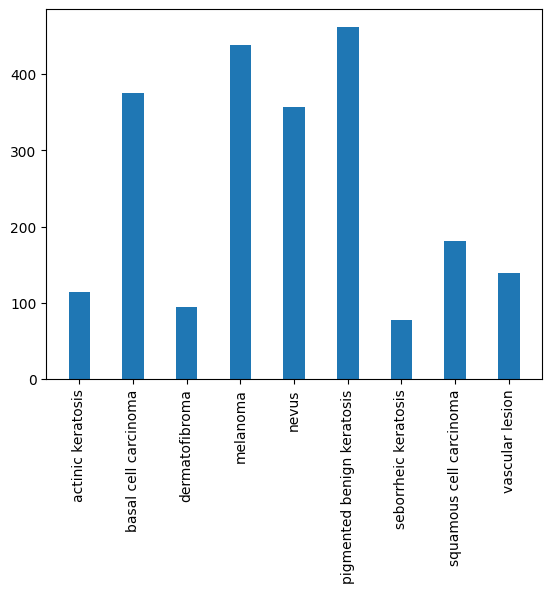

In [ ]:
data_old = df_old.groupby(by='Label').agg('count')
data_old['Label'] = data_old.index
plt.xticks(rotation=90)
plt.bar(data_old['Label'], data_old['Path'], width=0.4)

In [ ]:
!pip install Augmentor
import Augmentor

### 4.1 Prepare Augmentor Layers


*   Random flip
*   Skew
*   Random Zoom
*   Random Distortion
*   Rotate



In [ ]:
for each_class in class_names:
    print("Working with class: ", each_class)
    augmentor = Augmentor.Pipeline(training_data_dir + each_class)
    augmentor.flip_random(probability=0.39)
    augmentor.skew(probability=0.17)
    augmentor.greyscale(probability=0.01)
    augmentor.zoom_random(probability=0.17, percentage_area=0.11)
    augmentor.random_distortion(probability=0.31, grid_width=input_image_width, grid_height=input_image_height, magnitude=1)
    augmentor.rotate(probability=0.13, max_left_rotation=10, max_right_rotation=12)
    augmentor.sample(500)

Working with class:  actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E2DAD18D180>: 100%|██████████| 500/500 [02:44<00:00,  3.03 Samples/s]


Working with class:  basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E2D9C358310>: 100%|██████████| 500/500 [02:31<00:00,  3.31 Samples/s]


Working with class:  dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E2D9C483F10>: 100%|██████████| 500/500 [02:26<00:00,  3.41 Samples/s]


Working with class:  melanoma
Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=L size=1024x768 at 0x7E2D9C301DB0>: 100%|██████████| 500/500 [03:24<00:00,  2.45 Samples/s]


Working with class:  nevus
Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7E2D9C288A30>: 100%|██████████| 500/500 [03:03<00:00,  2.72 Samples/s]


Working with class:  pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=L size=600x450 at 0x7E2D9C542170>: 100%|██████████| 500/500 [02:33<00:00,  3.26 Samples/s]


Working with class:  seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E2D9C079930>: 100%|██████████| 500/500 [02:37<00:00,  3.17 Samples/s]


Working with class:  squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E2D9C35BA30>: 100%|██████████| 500/500 [02:20<00:00,  3.57 Samples/s]


Working with class:  vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E2D9C5CC9A0>: 100%|██████████| 500/500 [02:21<00:00,  3.53 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
path_list_new = list(data_dir_train.glob('*/output/*.jpg'))
print("Newly Generated Images Count:", len(path_list_new))

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list_new]
print(set(lesion_list_new), " Categories of Newly Generated Images:", len(lesion_list_new))

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

df_new = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

Newly Generated Images Count: 4500
{'seborrheic keratosis', 'vascular lesion', 'melanoma', 'actinic keratosis', 'squamous cell carcinoma', 'pigmented benign keratosis', 'dermatofibroma', 'nevus', 'basal cell carcinoma'}  Categories of Newly Generated Images: 4500


In [ ]:
[os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list_new]

<BarContainer object of 9 artists>

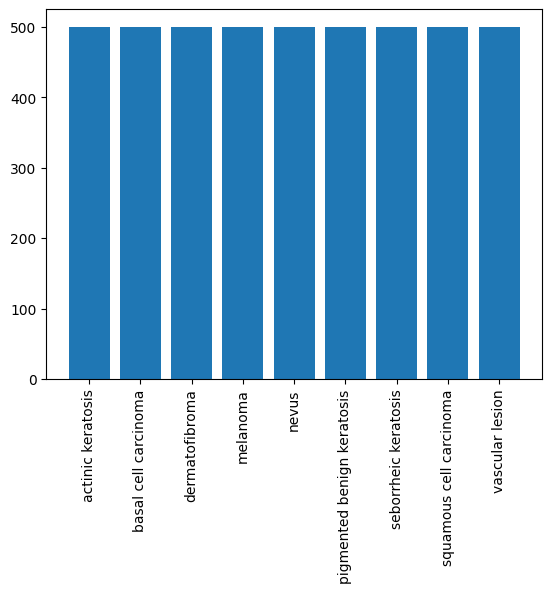

In [ ]:
data_new = df_new.groupby(by='Label').agg('count')
data_new['Label'] = data_new.index
plt.xticks(rotation=90)
plt.bar(data_new['Label'], data_new['Path'], width=0.8)

In [ ]:
new_images_parent_path = pd.DataFrame([[os.path.basename(os.path.dirname(os.path.dirname(y))), os.path.dirname(y) ] for y in path_list_new], columns=('class_name', 'directory_path')).drop_duplicates()
new_images_parent_path.directory_path[0]

'/content/drive/MyDrive/M/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output'

In [ ]:
lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in path_list_old]
print(set(lesion_list_old), " Categories of Existing Generated Image files:",  len(lesion_list_old))

{'seborrheic keratosis', 'vascular lesion', 'melanoma', 'actinic keratosis', 'squamous cell carcinoma', 'pigmented benign keratosis', 'dermatofibroma', 'nevus', 'basal cell carcinoma'}  Categories of Existing Generated Image files: 2239


In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))


df_new = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df_old = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

consolidated_df =pd.concat([df_new, df_old])

consolidated_df['Label'].value_counts()


pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

<BarContainer object of 9 artists>

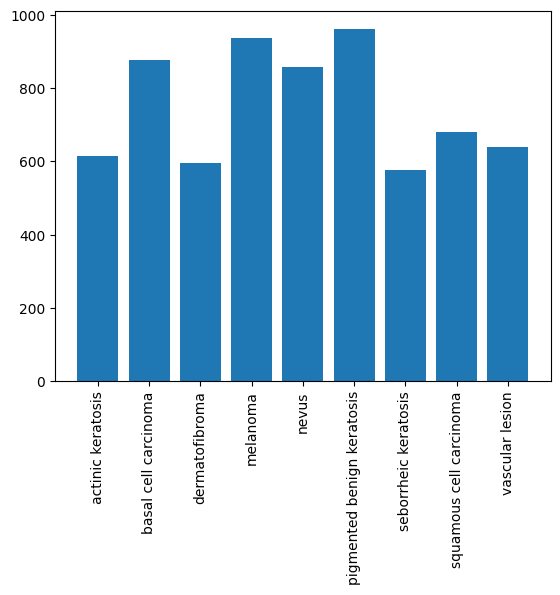

In [ ]:
data_consolidated = consolidated_df.groupby(by='Label').agg('count')
data_consolidated['Label'] = data_consolidated.index
plt.xticks(rotation=90)
plt.bar(data_consolidated['Label'], data_consolidated['Path'], width=0.8)

<BarContainer object of 9 artists>

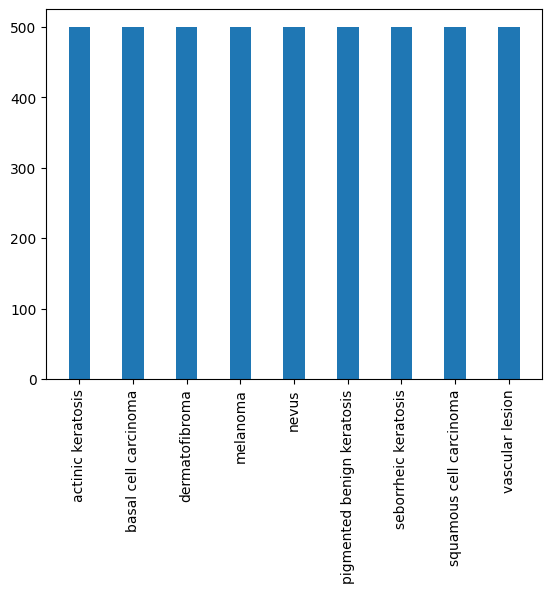

In [ ]:
data_new = df_new.groupby(by='Label').agg('count')
data_new['Label'] = data_new.index
plt.xticks(rotation=90)
plt.bar(data_new['Label'], data_new['Path'], width=0.4)

In [ ]:
df_new['Label'].value_counts()

pigmented benign keratosis    500
actinic keratosis             500
seborrheic keratosis          500
basal cell carcinoma          500
squamous cell carcinoma       500
dermatofibroma                500
melanoma                      500
nevus                         500
vascular lesion               500
Name: Label, dtype: int64

## 5. Training with a new Dataset including the Augmented Images

### 5.1 Reading Data for Training

In [ ]:
new_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=123,
    validation_split=0.2,
    subset='training',
    label_mode='categorical',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

new_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=123,
    validation_split=0.2,
    subset='validation',
    label_mode='categorical',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
print('New Images in Train:', len(new_train_ds.file_paths))
print('New Images in Validation:', len(new_val_ds.file_paths))

class_names = new_train_ds.class_names
print('The Class Names are: ', class_names)

New Images in Train: 5392
New Images in Validation: 1347
The Class Names are:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
new_train_ds = new_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
new_val_ds = new_val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### 5.1. Training using Model 2

In [ ]:
model2 = get_model()
model2.build(new_train_ds.as_numpy_iterator().next()[0].shape)

In [ ]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 179, 179, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 179, 179, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 178, 178, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)     

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, weight_decay=1e-6)
model2.compile(optimizer=optimizer,
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
new_hist_2 = model2.fit(new_train_ds, epochs = epochs, validation_data=new_val_ds)

Epoch 1/20
169/169 [==============================] - 41s 235ms/step - loss: 2.1658 - accuracy: 0.1628 - val_loss: 2.0287 - val_accuracy: 0.2123
Epoch 2/20
169/169 [==============================] - 32s 188ms/step - loss: 1.9983 - accuracy: 0.2268 - val_loss: 1.9885 - val_accuracy: 0.2012
Epoch 3/20
169/169 [==============================] - 34s 200ms/step - loss: 1.8332 - accuracy: 0.2980 - val_loss: 1.7805 - val_accuracy: 0.3356
Epoch 4/20
169/169 [==============================] - 32s 189ms/step - loss: 1.6912 - accuracy: 0.3720 - val_loss: 1.5569 - val_accuracy: 0.3912
Epoch 5/20
169/169 [==============================] - 33s 195ms/step - loss: 1.5883 - accuracy: 0.4024 - val_loss: 1.5776 - val_accuracy: 0.4128
Epoch 6/20
169/169 [==============================] - 32s 191ms/step - loss: 1.5226 - accuracy: 0.4280 - val_loss: 1.4688 - val_accuracy: 0.4365
Epoch 7/20
169/169 [==============================] - 32s 190ms/step - loss: 1.4623 - accuracy: 0.4547 - val_loss: 1.6680 - val_ac

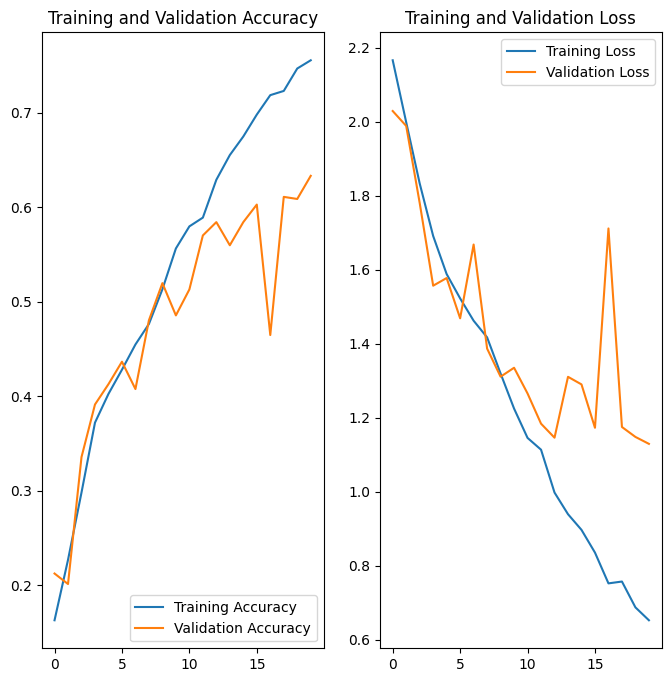

In [ ]:
visualize_outputs(new_hist_2)

- There is no change in the outcome with adding just the data. We need to adjust the layers for the model to perform better.

### 5.2. Training with Model 3

In [ ]:
def get_model_with_bn():
    model = keras.Sequential()
    model.add(keras.layers.Rescaling(1./255, input_shape=(input_image_height, input_image_width, 3)))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
    model.add(Dropout(0.25))

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(class_names), activation='softmax'))
    return model

In [ ]:
model3 = get_model_with_bn()
model3.build(new_train_ds.as_numpy_iterator().next()[0].shape)
print(model3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 179, 179, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 179, 179, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 178, 178, 64)     0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 178, 178, 64)     

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, weight_decay=1e-6)
model3.compile(optimizer=optimizer,
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
new_hist_3 = model3.fit(new_train_ds, epochs = epochs, validation_data=new_val_ds)

Epoch 1/20
169/169 [==============================] - 39s 225ms/step - loss: 2.5199 - accuracy: 0.1417 - val_loss: 11.0118 - val_accuracy: 0.0898
Epoch 2/20
169/169 [==============================] - 38s 223ms/step - loss: 2.1886 - accuracy: 0.1397 - val_loss: 17.4234 - val_accuracy: 0.0891
Epoch 3/20
169/169 [==============================] - 38s 223ms/step - loss: 2.1845 - accuracy: 0.1434 - val_loss: 29.4729 - val_accuracy: 0.0891
Epoch 4/20
169/169 [==============================] - 38s 222ms/step - loss: 2.1817 - accuracy: 0.1434 - val_loss: 39.4640 - val_accuracy: 0.0891
Epoch 5/20
169/169 [==============================] - 38s 222ms/step - loss: 2.1798 - accuracy: 0.1434 - val_loss: 43.5927 - val_accuracy: 0.0891
Epoch 6/20
169/169 [==============================] - 37s 222ms/step - loss: 2.1785 - accuracy: 0.1434 - val_loss: 44.6288 - val_accuracy: 0.0891
Epoch 7/20
169/169 [==============================] - 37s 222ms/step - loss: 2.1777 - accuracy: 0.1434 - val_loss: 44.8066 -

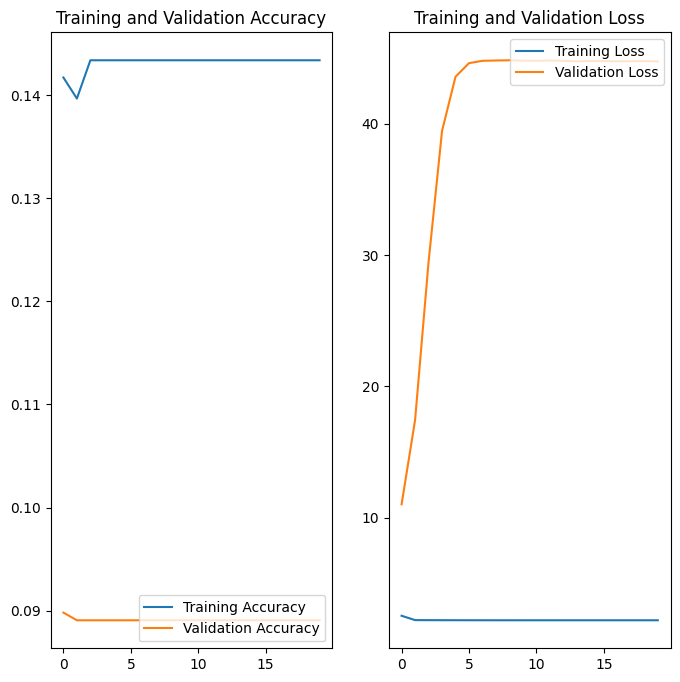

In [ ]:
visualize_outputs(new_hist_3)

- Model 3 is not working as desired and has very poor accuracy and loss metrics.

### 5.3. Training with Model 4

In [ ]:
def get_model_with_bn_and_regularization():
    model = keras.Sequential()
    model.add(keras.layers.Rescaling(1./255, input_shape=(input_image_height, input_image_width, 3)))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dropout(0.15))
    model.add(Dense(128, kernel_regularizer=l2(0.01)))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(class_names), activation='softmax'))
    return model

In [ ]:
model_4 = get_model_with_bn_and_regularization()
model_4.build(new_train_ds.as_numpy_iterator().next()[0].shape)

print(model_4.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 179, 179, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 179, 179, 64)      36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 178, 178, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 178, 178, 32)     

In [ ]:
#optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, weight_decay=1e-6)
model_4.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Epoch 1/20
169/169 [==============================] - 31s 181ms/step - loss: 1.4238 - accuracy: 0.4651 - val_loss: 1.1999 - val_accuracy: 0.5526
Epoch 2/20
169/169 [==============================] - 31s 182ms/step - loss: 1.2886 - accuracy: 0.5252 - val_loss: 1.1012 - val_accuracy: 0.6219
Epoch 3/20
169/169 [==============================] - 31s 184ms/step - loss: 1.2024 - accuracy: 0.5564 - val_loss: 1.0272 - val_accuracy: 0.6130
Epoch 4/20
169/169 [==============================] - 31s 183ms/step - loss: 1.1259 - accuracy: 0.5875 - val_loss: 0.9490 - val_accuracy: 0.6242
Epoch 5/20
169/169 [==============================] - 31s 184ms/step - loss: 1.0125 - accuracy: 0.6307 - val_loss: 0.9235 - val_accuracy: 0.6667
Epoch 6/20
169/169 [==============================] - 31s 184ms/step - loss: 0.9320 - accuracy: 0.6539 - val_loss: 0.7996 - val_accuracy: 0.7271
Epoch 7/20
169/169 [==============================] - 31s 184ms/step - loss: 0.9428 - accuracy: 0.6530 - val_loss: 0.8371 - val_ac

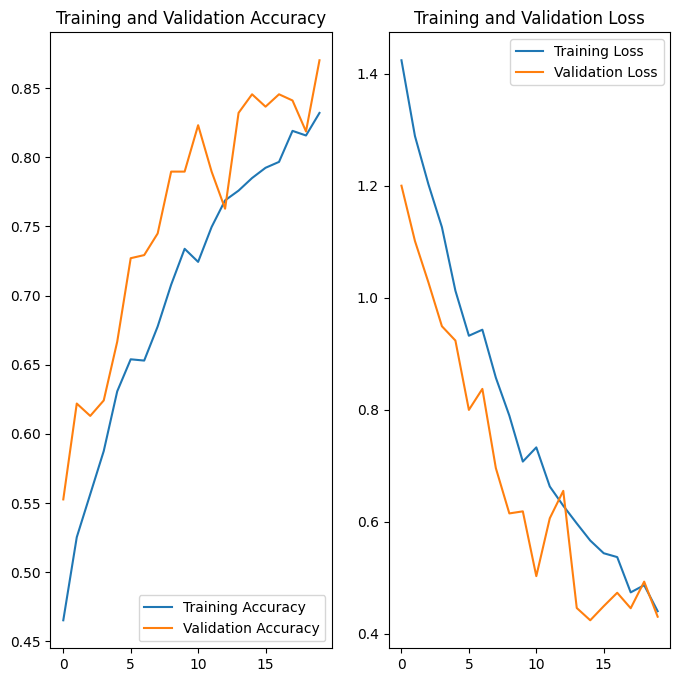

In [ ]:
new_hist_4 = model.fit(new_train_ds, epochs = epochs, validation_data=val_ds)

visualize_outputs(new_hist_4)

- This version of model has given better accuracy of 83%. Also, the error rate has also drastically reduced. We'll make use of this model for testing....

## 6. Testing

In [ ]:
final_model = model_4

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
          testing_data_dir,
          labels='inferred', seed=123,
          validation_split=None,
          subset=None,
          label_mode='categorical',
          image_size=(input_image_height, input_image_width),
          batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [ ]:
print("Testing Dataset ClassNames: ", test_ds.class_names)

Testing Dataset ClassNames:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
test_predictions = final_model.predict(test_ds, batch_size=batch_size, workers=4)

4/4 [==============================] - 24s 402ms/step


In [ ]:
unbatched_data = test_ds.unbatch()

In [ ]:
actual_test_labels = [np.argmax(label) for image, label in unbatched_data.as_numpy_iterator()]
predicted_test_labels = np.argmax(test_predictions, axis=1)

In [ ]:
pd.DataFrame({'actual': actual_test_labels, 'predicted': predicted_test_labels})

,actual,predicted
0,2,7
1,6,7
2,5,7
3,0,7
4,0,7
...,...,...
113,1,7
114,0,7
115,7,7
116,0,4


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
print("Testing data Accuracy score:", accuracy_score(actual_test_labels, predicted_test_labels))

Testing data Accuracy score: 0.11864406779661017
